# Keywords and Beer Styles

We want to extract what people say (i.e., what they mention) when writing a good review. Intuitively, we expect people to write about different beer styles differently. For example, when writing a review about a Grape beer, one would mention citrus notes. These style differences motivate us to look at keywords in reviews differently per style. 
We want to extract these keywords in general and obtain keywords specific to the time the review is written.

1. We analyze beer styles by selecting the most reviewed ones

2. Next, we analyze the keywords used in a review that correlate with a high rating. We analyze style and we call these keywords **overall keywords**.

3. We show that **rating trends** during the year are different for the most popular beers. That motivates to search for seasonal keywords differently for each beer style. 

4. Finally, we extract **seasonal keywords** which influence the rating.

## Notebook outline
   * [Most rated styles](#Most-rated-styles)
       * [Overall keywords](#Overall-keywords)
       * [Monthly trends](#Monthly-trends)
       * [Seasonal keywords](#Seasonal-keywords)
        
        
        

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
import spacy
from wordcloud import WordCloud

In [2]:
# laod beer reviews
DATA_PATH = './datasets/BeerAdvocate/'
PLOTS_DATA_PATH = './plots_data/'
reviews = pd.read_pickle(DATA_PATH + 'reviews.pkl')

## Most rated styles

We select the 15 most rated beer styles.

In [3]:
# 15 most rated beer styles
top_styles = reviews.groupby('Style')['Date'].count().sort_values(ascending=False).head(15)
top_styles = pd.DataFrame(top_styles.rename('Frequency'))

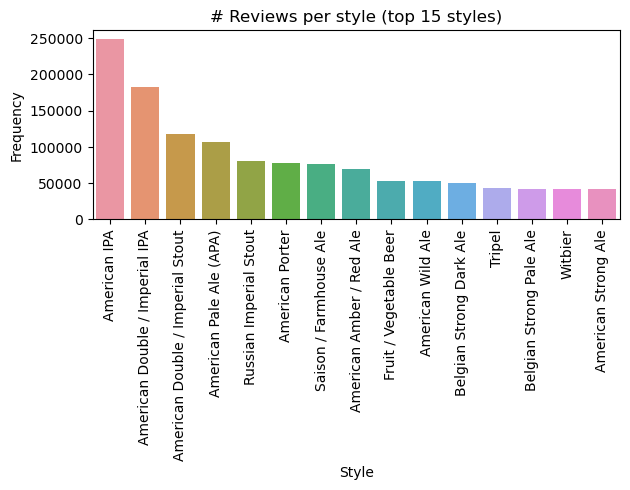

In [4]:
# visualize number of reviews for popular plots
sns.barplot(data=top_styles, x=top_styles.index, y=top_styles.Frequency)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('# Reviews per style (top 15 styles)')
plt.show()

In [5]:
# least rated popular beer
top_styles.tail(1)

,Frequency
Style,
American Strong Ale,41431


We see that the 15th most popular style has more than 40k ratings. Therefore, the conclusions in this section have enough data points to be valid.

_Note : For data story this plot is generated using JavaScript (corresponds to the same data and same plot type)_

### Overall keywords

In our work we investigate how the user text influences ratings. In this section we will infer the words in reviews that are correlated with high ratings.

In [6]:
# load spacy stop words (to be ignored as keywords)
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('t')
spacy_stopwords.add('quot')

In [7]:
# split text into lowercase tokens (words)
def get_words(text):
    word_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    word_list = word_tokenizer.tokenize(text)
    lowercase_words = list(map(lambda x: x.lower(),word_list))
    return lowercase_words

# for given dataframe df_reviews generate Series with top_k most common words
def generate_counts(df_reviews, top_k=100):
    words = (df_reviews)['Text'].apply(get_words).explode()
    counts = words.value_counts()[:top_k]
    return counts

# return is the keyword in list words
def get_indicator(words, keyword):
    return int(keyword in words)

**Methodology** : For each popular style, we fit a linear regression with variables of indicators of the most common words for that style. We don't include stop words as covariates. Therefore, the formula for each style is:

$ Rating = \sum_{word} {\alpha_{i} I (word)}$ 

where word is a common word for that style.  

We select only those words for which the p-value is less than 0.05. To include only the most influential keywords, we keep only the words for which the change in the grade is greater than 0.1 when having this word. We denote the obtained words as **overall keywords**.

In [9]:
# for given style and set list of words:
# select reviews of that style, fit linear regression with indicator of words
# return keywords, regression coefficients and p-values
# keep only those coefficients for which p-value is smaller than 0.05
# and the influence on the rating is higher than 0.01
def extract_keywords(style, words, coeff_thresh=0.1):
    coefficients = {} # dictionary with keyword coefficients : style+keyword -> coefficient
    pvalues = {} # dictionary with keyword pvalues : style+keyword -> p-value
    keywords = []

    # generate formula iteratively
    formula = "Rating ~ "
    cnt = 0 # count number of words in formula
    all_rev = reviews[reviews.Style==style].copy() # slice only reviews of this style
    all_rev['Words'] = all_rev['Text'].apply(get_words) # add column with words
    for keyword in words:
            if cnt == 0:
                formula = formula + keyword
            else:
                formula = formula + " + " + keyword

            all_rev[keyword] = all_rev['Words'].apply((lambda words: get_indicator(words,keyword)))
            cnt += 1

    # fit linear regression
    model = smf.ols(formula=formula, data=all_rev).fit()

    # find words for which p values is <0.05 and change in the grade is higher than coeff_thresh
    for keyword in words:
        if model.pvalues[keyword] < 0.05 and abs(model.params[keyword]) > coeff_thresh:
            keywords.append(keyword)
            coefficients[style + keyword] = model.params[keyword]
            pvalues[style + keyword] = model.pvalues[keyword]
    return keywords, coefficients, pvalues

In [10]:
# find overall keywords for each style
keywords_style = {} # style -> [list of frequent words]
coefficent_style = {} # style+keyword -> LR coefficient
pvalues_style = {} # style+keyword -> p-value
for style in top_styles.index:
    # generate counts for this style
    counts = generate_counts(reviews[reviews.Style == style], top_k=100)
    # remove stop words
    freq_words = list(counts[~counts.index.isin(list(spacy_stopwords))].index)

    # for each style fit a LR with indicator of frequent words as covariates
    # extract which words have p-value<0.05 and influence on the grade for more than 0.1
    keywords_style[style], coef, pvals = extract_keywords(style, freq_words)
    coefficent_style.update(coef)
    pvalues_style.update(pvals)

In [11]:
# convert results to dataframe
keywords_df = pd.DataFrame(pd.concat({k: pd.Series(v) for k, v in keywords_style.items()})).reset_index()
keywords_df = keywords_df.rename(columns={'level_0':'Style', 'level_1':'Word Id', 0:'Keyword'})
keywords_df['Coefficient'] = keywords_df.apply(lambda x : coefficent_style[x['Style'] + x['Keyword']], axis=1)
keywords_df['PValue'] = keywords_df.apply(lambda x : pvalues_style[x['Style'] + x['Keyword']], axis=1)

# get positive and negative keywords
positive_keywords = set(keywords_df[keywords_df.Coefficient > 0].Keyword)
negative_keywords = set(keywords_df[keywords_df.Coefficient < 0].Keyword)

Let's visualize the keywords that have a positive impact on the rating! The size of the word in the cloud corresponds to the number of popular beer styles for which this word is the keyword.

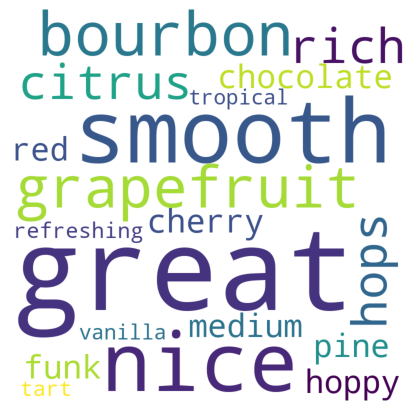

In [24]:
# select positive keywords and create the cloud based on frequencies of styles
# the cloud represents the union of keywords across all styles
most_common = keywords_df[keywords_df.Coefficient > 0].groupby('Keyword').count()[['Style']].reset_index()
wordcloud = WordCloud(width = 800, height = 800, background_color ='white',
                      min_font_size = 10).generate_from_frequencies(dict(zip(most_common.Keyword, most_common.Style)))
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig(PLOTS_DATA_PATH + 'word_cloud.png', transparent=True)
plt.show()

Now we separate the obtain words per beer aspect (if applicable):

**Positive**:

**Taste** : grapefruit, citrus, cherry, chocolate, hops, hoppy, vanilla, tart, pine, funk, bourbon, tropical

**Aroma** : grapefruit, citrus, cherry, chocolate, hops, hoppy, vanilla, pine, funk, bourbon, tropical

**Palate** : smooth, refreshing, rich, tropical

**Appearance** : red, tropical

**Other** : great, nice, medium

**Negative** :

**Palate** : thin

**Other** : like

Let's now see the order of the influce for some of these keywords on the rating for particular style:

In [20]:
# show some keywords, coefficients and p-values
keywords_df.sample(10)

,Style,Word Id,Keyword,Coefficient,PValue
0,American IPA,0,grapefruit,0.118606,0.000000e+00
32,Fruit / Vegetable Beer,1,nice,0.275117,0.000000e+00
47,Witbier,1,refreshing,0.153735,1.150583e-130
21,American Porter,3,thin,-0.138190,2.512240e-231
17,Russian Imperial Stout,3,rich,0.113129,3.954194e-159
46,Witbier,0,nice,0.192432,1.500312e-267
30,American Amber / Red Ale,6,pine,0.151460,1.847270e-170
1,American IPA,1,great,0.186501,0.000000e+00
22,Saison / Farmhouse Ale,0,funk,0.102775,6.307633e-144
19,American Porter,1,smooth,0.138728,1.612060e-269


In [32]:
# negative influence overall keywords
keywords_df[keywords_df.Coefficient < 0]

,Style,Word Id,Keyword,Coefficient
21,American Porter,3,thin,-0.138190
31,Fruit / Vegetable Beer,0,like,-0.125838
36,Fruit / Vegetable Beer,5,thin,-0.104546


In [21]:
keywords_df.PValue.max()

2.5030747866103597e-40

**All** the p-values for **overall keywords** are smaller than $10^{-39}$

In [31]:
keywords_df.to_csv(PLOTS_DATA_PATH + 'overall_keywords.csv')

_Note : For data story this dataframe is visualized uzing Java Script by making bubbles from the coefficient columns per style_ 

**Conclusion:** 
1. The most words are related to **Taste** and **Aroma** and that matches to what we concluded in the previous parts : these 2 aspects influence increase in the grade the most.
2. The most of the overall keywords positively affect the grade, with a few overall keywords that have negative influence. As we expected, the overall keywords are style dependent.

### Monthly trends

Another useful feature is the timestamp the beer review was given. This section delves deep into monthly rating trends for popular styles as a first step towards **seasonal keywords**.

For that matter, we first look into the monthly trends:

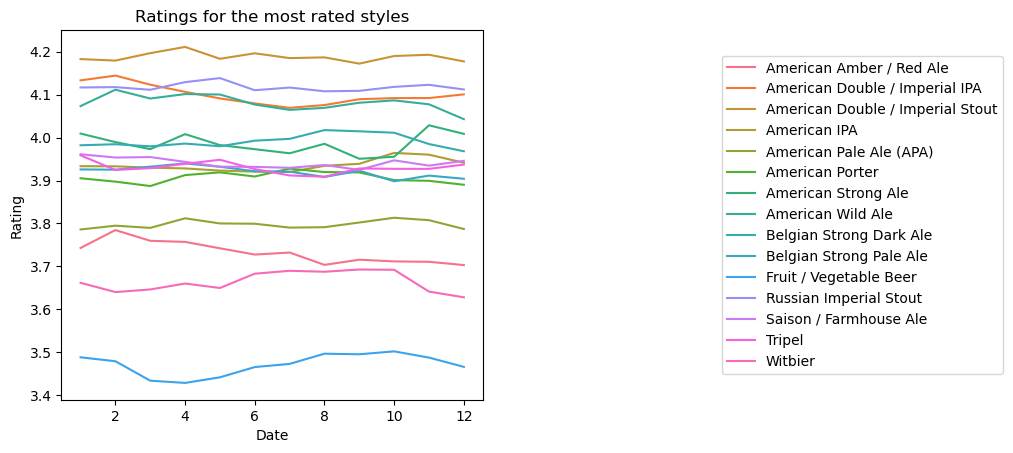

In [22]:
# visualize rating trends during the year (for top 15 rated beers)
top_reviews = reviews[reviews.Style.isin(top_styles.index.to_list())]
monthly_trends_summer_pop = top_reviews.groupby(['Style', reviews['Date'].dt.month])['Rating'].mean()
df = pd.DataFrame(monthly_trends_summer_pop).reset_index()
g = sns.lineplot(data=df, x='Date', y='Rating', hue='Style')
box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
g.legend(loc='center right', bbox_to_anchor=(2.25, 0.5), ncol=1)
plt.title('Ratings for the most rated styles')
plt.show()

Our initial analysis (notebook _data_investigation.ipynb_) concluded that across all beer types, the ratings in summer months are lower than in winter months. From the plot above, we see that not all beers follow this trend. We also see that **differences between** ratings among **the styles** are considerable. For example, we see that Fruit/Vegetable beers are better rated during summer. For this style, we obtain a **Simpson paradox** (the monthly trend is different than the overall trend per style). If this beer was more drank during summer, that would downgrade the general trend, so we can look at which beer styles were drank in which period.

However, the biggest takeaway from this plot is that different beer styles are very differently graded! Look at the y-axis! This difference is another reason why the keywords (in this case seasonal keywords) should be extracted per style. 

_Note : The plot above for datastory is generated using JavaScript (it corresponds to the same data and the same plot type)_

In [23]:
# adding columns for month, indicator for summer and indicator for winter
reviews['Month'] = reviews.Date.dt.month
reviews['Summer'] = reviews.Month.apply(lambda x : 1 if x in [7, 8, 9] else 0)
reviews['Winter'] = reviews.Month.apply(lambda x : 1 if x in [1, 2, 3] else 0)

# reviews given during summer
summer_df = reviews[reviews.Summer == 1]
# reviews given during winter
winter_df = reviews[reviews.Winter == 1]

In [24]:
# caclulate summer increase consumption of Fruit/Vegetable beers
fruit_beer_summer_increase = 100*(len(summer_df[summer_df.Style == 'Fruit / Vegetable Beer']) \
                                  /len(winter_df[winter_df.Style == 'Fruit / Vegetable Beer'])-1)

print('The summer increase of reviews of Fruit/Vegetable beers : {:.3f}%'.format(fruit_beer_summer_increase))                                                                 

The summer increase of reviews of Fruit/Vegetable beers : 34.652%


Therefore, since there are more reviews of `Fruit/Vegetable` beers during summer than during winter and the average grade of this style is way smaller than the overall grade of other popular styles (see graph above), the overall rating average (across all styles) is downgraded during the summer. 

Similarly, we conclude that upgrade of grades during winter is partially coming from `American Double/Imperial Stout` style. This is the 3rd most popular beer overall and from the graph above we see that it has the best ratings across all months!

In [30]:
# caclulate winter increase consumption of American Double/Imperial Stout
usa_imp_ipa = 100*(len(winter_df[winter_df.Style == 'American Double / Imperial Stout']) \
                                  /len(summer_df[summer_df.Style == 'American Double / Imperial Stout'])-1)

print('The winter increase of reviews of American Double/Imperial Stout beers : {:.3f}%'.format(usa_imp_ipa))  

The winter increase of reviews of American Double/Imperial Stout beers : 56.212%


**Conclusions**:
1. Beer styles have considerable differences in ratings, so seasonal keywords must be extracted for each style separately 
2. People prefer different beer styles throughout the year. Some styles are more or better rated (and drank) in summer, while others in winter. Therefore, when finding seasonal keywords we need to take into account that for different beerstyles we have different periods with highest and lowest grades.  

### Seasonal keywords

So, for calculating seasonal keywords, we will first extract the ratings for the worst and best graded month, compare the frequencies and get the candidates for seasonal keywords. That is: the keywords that appear 10% more or 10% less in the highest-rated month compared to the lowest-rated. Next, when we obtained the candidates, we use linear regression to determine which candidates significantly influence the beer ratings.

**Methodology**: We find the best and worst-rated month on average for each beer style. We extract 100 most common words in reviews for each period. We choose as candidates only those words that appear 10% more in one of the 2 months. This is done to obtain only those words that "have a chance" to make an influence.

Once the candidates are obtained, we fit the linear regression on all the reviews of the style with the indicators of candidates words. Then by looking at p-values and the indicator coefficients, we conclude what words influence the rating the most. We denote these words as **seasonal keywords**.

The formula is:
$ Rating = \sum_{candidate} {\alpha_{i} I (candidate)}$ 
, where the candidates are taken as explained above. 


In [26]:
# obtaining months with lowest and highest grade
popular_reviews = reviews[reviews.Style.isin(top_styles.index.to_list())]
monthly_trends_pop = popular_reviews.groupby(['Style', reviews['Date'].dt.month])['Rating'].mean()
monthly_trends = pd.DataFrame(monthly_trends_pop).reset_index().set_index('Date')
grouped = monthly_trends.groupby(['Style'])
max_month = pd.DataFrame(grouped['Rating'].idxmax()).rename(columns={'Rating' : 'MaxMonth'})
min_month = pd.DataFrame(grouped['Rating'].idxmin()).rename(columns={'Rating' : 'MinMonth'})
peaks = min_month.join(max_month)
peaks

,MinMonth,MaxMonth
Style,,
American Amber / Red Ale,12,2
American Double / Imperial IPA,7,2
American Double / Imperial Stout,9,4
American IPA,7,10
American Pale Ale (APA),1,10
American Porter,3,7
American Strong Ale,9,11
American Wild Ale,12,2
Belgian Strong Dark Ale,12,8


We confirm again that the lowest graded and the best graded months vary across the beer styles! Now let's find **candidates**. Out of top 100 words for winner and loser month, let's find those words that appear 10% more in one of these 2 months:

In [27]:
# extracting candidates (for seasonal keywords) and do linear regression on them for each style

n = 100 # consider only 100 top words for min and max month
thresh = 0.1 # consider only words that appear 10% more in one month (min compare to max, or vice versa)
selected_styles = list(top_styles.index)
coeff_thres = 0.1 # consider only covariates that influence the grade for more than 0.1

seasonal_keywords = {} # dictionary of keywords : style -> [list of keywords for that style]
seasonal_coefficients = {} # dictionary with keyword coefficients : style+keyword -> coefficient
seasonal_pvalues = {} # dictionary with pvalues : style+keyword -> pvalue

for style in selected_styles:
    curr_candidates = []

    # select reviews from lowest and highest month
    min_reviews = reviews[(reviews.Month==peaks.loc[style]['MinMonth'])&(reviews.Style==style)].copy()
    max_reviews = reviews[(reviews.Month==peaks.loc[style]['MaxMonth'])&(reviews.Style==style)].copy()
    
    # get words
    min_words = (min_reviews)['Text'].apply(get_words).explode()
    max_words = (max_reviews)['Text'].apply(get_words).explode()

    # get top n words
    min_counts = min_words.value_counts()[:n]
    max_counts = max_words.value_counts()[:n]
    
    # get counts
    min_large = min_words.value_counts()
    max_large = max_words.value_counts()
    
    # append keywords that are more frequent in min month
    for word in min_counts.keys():
        if word in spacy_stopwords: # don't include stop words in formula
            continue
        min_freq = min_counts[word]/len(min_words)
        max_freq = max_large[word]/len(max_words)
        if (min_freq-max_freq)/min_freq > thresh:    
            curr_candidates.append(word)
    # append keywords that are more frequent in max month
    for word in max_counts.keys():
        if word in spacy_stopwords: # don't include stop words in formula
            continue
        max_freq = max_counts[word]/len(max_words)
        min_freq = min_large[word]/len(min_words)
        if (max_freq-min_freq)/max_freq > thresh:
            curr_candidates.append(word)
            
    # for each style fit a LR with indicator of candidate words as covariates
    # extract which words have p-value<0.05 and influence on the grade for more than 0.1
    seasonal_keywords[style], coef, pval = extract_keywords(style, curr_candidates)
    seasonal_coefficients.update(coef)
    seasonal_pvalues.update(pval)

In [28]:
# convert results to dataframe
seasonal_keywords_df = pd.DataFrame(pd.concat({k: pd.Series(v, dtype='object') for k, v \
                                               in seasonal_keywords.items()})).reset_index()
seasonal_keywords_df = seasonal_keywords_df.rename(columns={'level_0':'Style', 'level_1':'Word Id', 0:'Keyword'})
seasonal_keywords_df['Coefficient'] = seasonal_keywords_df.apply(lambda x : 
                                                seasonal_coefficients[x['Style'] + x['Keyword']], axis=1)
seasonal_keywords_df['PValue'] = seasonal_keywords_df.apply(lambda x : 
                                                seasonal_pvalues[x['Style'] + x['Keyword']], axis=1)
seasonal_keywords_df.groupby('Keyword')['Word Id'].count().sort_values(ascending=False)

# how many styles with this seasonal keyword

Keyword
vanilla       3
fresh         2
great         2
nice          2
beers         1
bourbon       1
caramel       1
cherry        1
oak           1
pine          1
pumpkin       1
refreshing    1
tart          1
Name: Word Id, dtype: int64

In [29]:
seasonal_keywords_df.PValue.max()

1.478455850438253e-29

**All** the p-values for **seasonal keywords** are smaller than $10^{-28}$

##### Negative seasonal keywords

In [57]:
# seasonal keywords that have negative influence on the grade
seasonal_keywords_df[seasonal_keywords_df.Coefficient < 0]

,Style,Word Id,Keyword,Coefficient
1,American Double / Imperial IPA,0,caramel,-0.118599


The only seasonal keyword with **negative** influence is **caramel**. Let's get back to the best-rated and worst-rated months for this style.

In [58]:
# show months info for caramel related styles
peaks.loc[seasonal_keywords_df[seasonal_keywords_df.Keyword == 'caramel']['Style']]

,MinMonth,MaxMonth
Style,,
American Double / Imperial IPA,7,2


**Caramela** is significantly more present in July than in February (because it is a candidate word). Since its overall influence is negative, this trait of American Double/Imperial IPA bothers people more in July than in Febraury.

##### Positive seasonal keywords

In [59]:
# show LR info for fresh-related styles
seasonal_keywords_df[(seasonal_keywords_df.Keyword == 'fresh') | \
                     (seasonal_keywords_df.Keyword == 'refreshing')][['Style','Keyword', 'Coefficient']]

,Style,Keyword,Coefficient
0,American IPA,fresh,0.135115
4,American Pale Ale (APA),fresh,0.186084
15,Witbier,refreshing,0.168595


In [60]:
# show LR info for vanilla related styles
seasonal_keywords_df[(seasonal_keywords_df.Keyword == 'vanilla')][['Style','Keyword', 'Coefficient']]

,Style,Keyword,Coefficient
3,American Double / Imperial Stout,vanilla,0.116201
5,Russian Imperial Stout,vanilla,0.135693
17,American Strong Ale,vanilla,0.145952


We see that **fresh** and **vanilla** appear for 3 beer styles and have **positive influence** on the rating! For corresponding beer styles these traits are more noticed in particular periods since it is a candidate word.

Let's get back to the best-rated and worst-rated months for these 3 styles.

In [61]:
# show months info for vanilla related styles
peaks.loc[seasonal_keywords_df[seasonal_keywords_df.Keyword == 'vanilla']['Style']]

,MinMonth,MaxMonth
Style,,
American Double / Imperial Stout,9,4
Russian Imperial Stout,8,5
American Strong Ale,9,11


We see that these styles are favorable in changing seasons and least favorable in summer.

Let's see what is the case for `fresh`: 

In [62]:
# show months info for fresh related styles
peaks.loc[seasonal_keywords_df[(seasonal_keywords_df.Keyword == 'fresh') \
                               | (seasonal_keywords_df.Keyword == 'refreshing') ]['Style']]

,MinMonth,MaxMonth
Style,,
American IPA,7,10
American Pale Ale (APA),1,10
Witbier,12,9


The least-rated months for 2/3 styles are in winter and the best-rated ones are in early fall.
Therefore, people **appreaciate refreshing** beers more during **hotter** days.

**Conclusion**:
1. Refreshing trait of a beer has a positive influence on the rating and the trait is more noticed in summer 
2. Vanilla has positive influence on the rating for multiple beer styles notes are more recognized in spring/fall
3. Caramela can have negative influence on beer rating and it is more commented about in summer than in winter